# 🔬 Deep Dive: Python Object Model & Memory Optimization
This notebook provides a comprehensive exploration of Python's object internals, reference counting, memory layout, garbage collection, interning, and how to optimize memory using tools like `__slots__`, `weakref`, and diagnostics like `objgraph` and `tracemalloc`.

⚠️ This notebook assumes you're comfortable with Python classes, memory models, and want to go deep into CPython behavior.

## 1️⃣ Reference Counting & Garbage Collection
Every object in CPython has a reference count. When it reaches zero, the object is deallocated.

In [ ]:
import sys
import gc
import time

def track_memory(obj_name, obj):
    """
    Tracks the memory address of an object.

    Args:
        obj_name: The name of the object (for display).
        obj: The object to track.

    Returns:
        The object ID.
    """
    obj_id = id(obj)
    print(f"{obj_name} (ID: {obj_id}) allocated at: {hex(obj_id)}")
    return obj_id

def main():
    """
    Demonstrates memory management with and without cyclic references.
    """
    print("Demonstrating memory management WITHOUT a cyclic reference:")
    # 1. Without a cyclic reference
    a = [1, 2, 3]
    a_id = track_memory("a", a)  # Track object 'a'
    del a #reference a to the object goes but pointer exists
    gc.collect()  # Force garbage collection
    time.sleep(1)  # Give time for deallocation

    # Check if a_id is still valid
    try:
        print(f"Memory for 'a' (ID: {a_id}) still exists: {id(a)}")
    except NameError:
        print(f"Memory for 'a' (ID: {a_id}) was deallocated as expected.\n")

    print("Demonstrating memory management WITH a cyclic reference:")
    # 2. With a cyclic reference
    x = []
    y = x
    x.append(y)  # Create the cyclic reference
    x_id = track_memory("x", x)  # Track object 'x'
    del y  # Delete y first this time
    gc.collect()  # Force garbage collection
    time.sleep(1)  # Give time for deallocation
    # Check if x_id is still valid
    try:
        print(f"Memory for 'x' (ID: {x_id}) still exists: {id(x)}")
    except NameError:
        print(f"Memory for 'x' (ID: {x_id}) was deallocated by the garbage collector.\n")
    del x #delete x

    gc.collect()
    time.sleep(1)
    try:
        print(f"Memory for 'x' (ID: {x_id}) still exists: {id(x)}")
    except NameError:
        print(f"Memory for 'x' (ID: {x_id}) was deallocated by the garbage collector.\n")

if __name__ == "__main__":
    main()


## Explanation of the Code: Cyclic References and Garbage Collection

This code demonstrates how Python handles cyclic references and how the garbage collector works to clean them up.

**1. Creating a Cyclic Reference:**

   * `x = []`:  A list named `x` is created.
   * `y = x`:  The variable `y` is assigned to the same list object that `x` refers to.  Now, both `x` and `y` point to the same list.
   * `print("Reference count of x:", sys.getrefcount(x))`:  This line prints the reference count of the list that `x` (and `y`) refers to.  It's important to note that `sys.getrefcount(x)` itself increases the reference count by one temporarily, which is a crucial detail to remember.
   * `x.append(y)`:  This is the key step in creating a cyclic reference.  It appends the list `y` (which is the same as `x`) to the list `x`.  Now, the list `x` contains a reference to itself.
   * `del x`:  The name `x` is deleted.  However, the list object still exists because it's referenced by `y` and, more importantly, it contains a reference to itself.
   * `del y`:  The name `y` is also deleted.  Now, there are no more *external* references to the list.  However, the list still exists in memory because it holds a reference to itself.  This is a cyclic reference: the list object refers to itself, preventing its reference count from ever reaching zero in the traditional way.

**2. Garbage Collection:**

   * `print("Before GC: Garbage count =", gc.collect())`:
        * `gc.collect()`:  This function explicitly runs Python's garbage collector.
        * Cyclic references cannot be collected by the simple reference counting mechanism that Python uses.  The garbage collector is designed to identify and collect these cyclic references.
        * The `gc.collect()` function returns the number of unreachable objects that it collected.  In this case, it should collect the list that `x` and `y` used to point to.
        * The output of the print statement shows the number of objects collected by the garbage collector.



## Explanation of the Code: Cyclic References and Garbage Collection

This code demonstrates how Python handles cyclic references and how the garbage collector works to clean them up.

**1. Creating a Cyclic Reference:**

   * `x = []`:  A list named `x` is created.
   * `y = x`:  The variable `y` is assigned to the same list object that `x` refers to.  Now, both `x` and `y` point to the same list.
   * `print("Reference count of x:", sys.getrefcount(x))`:  This line prints the reference count of the list that `x` (and `y`) refers to.  It's important to note that `sys.getrefcount(x)` itself increases the reference count by one temporarily, which is a crucial detail to remember.
   * `x.append(y)`:  This is the key step in creating a cyclic reference.  It appends the list `y` (which is the same as `x`) to the list `x`.  Now, the list `x` contains a reference to itself.
   * `del x`:  The name `x` is deleted.  However, the list object still exists because it's referenced by `y` and, more importantly, it contains a reference to itself.
   * `del y`:  The name `y` is also deleted.  Now, there are no more *external* references to the list.  However, the list still exists in memory because it holds a reference to itself.  This is a cyclic reference: the list object refers to itself, preventing its reference count from ever reaching zero in the traditional way.

**2. Garbage Collection:**

   * `print("Before GC: Garbage count =", gc.collect())`:
        * `gc.collect()`:  This function explicitly runs Python's garbage collector.
        * Cyclic references cannot be collected by the simple reference counting mechanism that Python uses.  The garbage collector is designed to identify and collect these cyclic references.
        * The `gc.collect()` function returns the number of unreachable objects that it collected.  In this case, it should collect the list that `x` and `y` used to point to.
        * The output of the print statement shows the number of objects collected by the garbage collector.


In [ ]:
import gc
import sys
import time
import timeit

def track_memory(obj_name, obj):
    """Tracks memory address and object ID."""
    obj_id = id(obj)
    print(f"{obj_name} (ID: {obj_id}) allocated at: {hex(obj_id)}")
    return obj_id

def main():
    """Demonstrates GC behavior with and without cyclic references."""

    print("\n---Garbage Collection Demonstration---\n")

    print("1. No Cyclic Reference:")
    a = [1, 2, 3]
    a_id = track_memory("a", a)
    del a
    gc.collect()
    time.sleep(0.5)
    try:
        print(f"Memory for 'a' (ID: {a_id}) still exists: {id(a)}")
    except NameError:
        print(f"Memory for 'a' (ID: {a_id}) was deallocated as expected.")

    print("\n---GC Tuning and Invocation---\n")

    print("Automatic Invocation:")
    print("Python's GC runs automatically, triggered by memory allocation thresholds. Its goal is to reclaim memory occupied by unreachable objects.")

    print("\nManual Invocation (gc.collect()):")
    print("While automatic collection usually suffices, you can explicitly call `gc.collect()` to force garbage collection. Useful for:")
    print("- Testing memory leaks.")
    print("- Releasing memory when needed for specific tasks (e.g., after a large computation).")

    print("\nOverhead of GC:")
    print("GC introduces a performance overhead. Frequent manual invocation can hurt application speed.")

    # Measure the overhead of calling gc.collect()
    def gc_overhead_test():
        x = [i for i in range(10000)]  # Create some garbage
        del x
        gc.collect()

    num_iterations = 1000
    gc_overhead_time = timeit.timeit(gc_overhead_test, number=num_iterations)
    print(f"Time taken to call gc.collect() {num_iterations} times: {gc_overhead_time:.6f} seconds")

    print("\nTuning GC:")
    print("Python provides options to tune the GC. Experiment to fine-tune behavior.")
    print(f"Current GC thresholds: {gc.get_threshold()}")
    # Example of setting GC thresholds (Not recommended for general use without understanding the implications)
    # gc.set_threshold(1000, 5, 5)
    print("Tuning affects when the GC cycle begins and how frequently it runs. Read the Python documentation for details.")


if __name__ == "__main__":
    main()


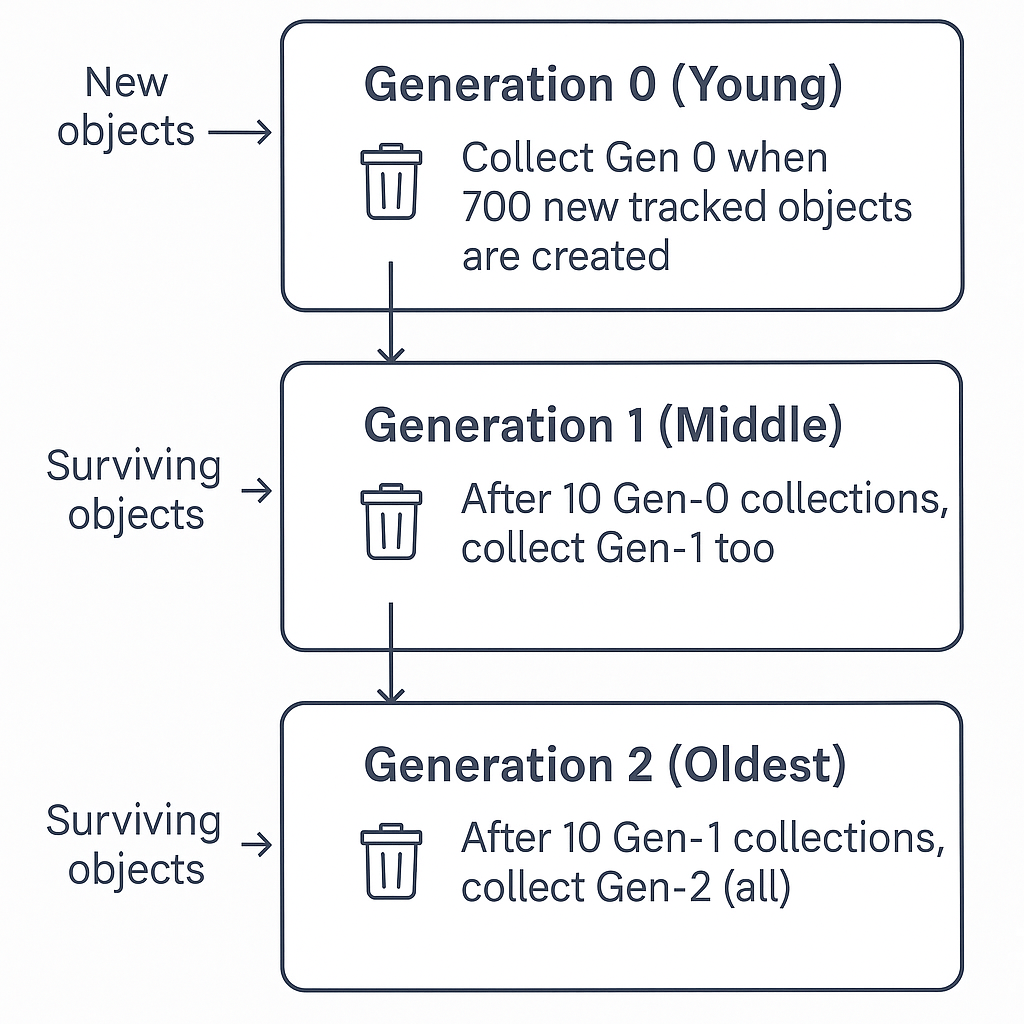

In [ ]:

for gen in range(3):
    print(f"Generation {gen} threshold:", gc.get_threshold()[gen])
    print(f"Objects in gen {gen}:", len(gc.get_objects()))


### 🔄 Generational Garbage Collection
CPython uses 3 generations (0, 1, 2). Objects that survive longer move up.

## 👻 Weak References and Object Lifetimes

# 🧠 Understanding Weak References in Python

## 📌 What is a Weak Reference?

In Python, most variables are **strong references** — they keep an object alive.

A **weak reference** is a reference to an object **that does not prevent it from being garbage collected**.

Think of it like:
> "I know this object, but I don't *own* it. If no one else wants it, it's free to go."

---

## ⚙️ Why Use Weak References?

- 🔁 **Avoid memory leaks** in caching or circular data structures.
- 🚮 **Let GC (Garbage Collector)** reclaim memory when nothing else uses the object.
- 🔄 **Track objects without keeping them alive.**

---

## 🧪 When Should You Use Them?

Use weak references when:
- You're building a **cache** and want unused items to disappear automatically.
- You're storing **back-references** (like parent links in trees) but don't want to cause cycles.
- You're observing or tracking objects without extending their lifespan.

---

## 🔍 Example: Weak Reference Basics

```python
import weakref

class MyClass:
    def __del__(self):
        print("Object is being destroyed")

obj = MyClass()
ref = weakref.ref(obj)

print("WeakRef points to:", ref())
del obj
print("After deletion, WeakRef:", ref())


In [ ]:

import weakref

class Data:
    def __del__(self):
        print("Data object deleted")

d = Data()
r = weakref.ref(d)
print("Weakref points to:", r())

del d
print("Weakref after deletion:", r())


Weakref points to: <__main__.Data object at 0x7f130f6c2a90>
Data object deleted
Weakref after deletion: None


In [ ]:
import time
import weakref

class UserProfile:
    def __init__(self, user_id):
        self.user_id = user_id
        print(f"⏳ Loading profile for user {user_id}...")
        time.sleep(1)  # Simulate expensive load
        print(f"✅ Profile {user_id} loaded.")

    def __repr__(self):
        return f"<UserProfile: {self.user_id}>"

# Auto-expiring cache: values are weakly referenced
user_cache = weakref.WeakValueDictionary()

def get_user_profile(user_id):
    # Check cache first
    profile = user_cache.get(user_id)
    if profile is not None:
        print(f"⚡ Cache hit for user {user_id}")
        return profile

    # Cache miss — load and store a weak reference
    profile = UserProfile(user_id)
    user_cache[user_id] = profile
    return profile

# --- Usage ---
print("🔁 First access:")
u1 = get_user_profile("alice")  # Cache miss

print("\n🔁 Second access:")
u2 = get_user_profile("alice")  # Cache hit

print("\n🗑️ Deleting all strong references to profile:")
del u1
del u2
import gc; gc.collect()

print("\n🔁 Third access after GC:")
u3 = get_user_profile("alice")  # Cache miss again (was auto-removed)


Excellent — and this is the **crux** of the confusion. Let's get it absolutely clear:

---

### ❌ **Wrong Idea**:

> *Use weak references to prevent GC from removing cached objects.*

No — that’s **not** why we use `weakref`.

---

### ✅ **Correct Idea**:

> **Use weak references so that cached objects are removed *automatically* when they’re no longer used elsewhere.**

---

### Here's the real need:

Let’s say you build a cache of expensive objects, like:

```python
cache = {}  # normal dictionary
```

Now:

* You load a profile and store it: `cache[user_id] = profile`
* Even if nothing else is using that `profile`, it **stays alive forever** because your cache is holding a **strong reference**.

🎯 **Problem**: You have to **manually evict** old items or they cause memory leaks.

---

### 💡 Solution: `WeakValueDictionary`

```python
cache = weakref.WeakValueDictionary()
```

Now:

* If **somewhere else** in your code is still using the object → it stays alive.
* But if **no one else is using it**, it gets **garbage collected**, and the cache auto-removes the entry!

---

### 🔁 Summary

| Feature                     | Strong dict (`{}`) | WeakValueDictionary            |
| --------------------------- | ------------------ | ------------------------------ |
| Keeps object alive?         | ✅ Yes              | ❌ No — only if used elsewhere  |
| Auto-evicts unused entries? | ❌ No — manual only | ✅ Yes, when GC reclaims object |
| Prevents memory leaks?      | ❌ Not by default   | ✅ Automatically                |

---

So:

> We use **weak references in a cache to allow GC to remove entries automatically**, without us having to track usage or write cleanup code.




## 🔢 Small Integer and String Interning
Python caches small integers in [-5, 256] and interns certain strings.

In [ ]:

import sys
a = 100
b = 100
print("a is b:", a is b)

x = 1000
y = 1000
print("x is y:", x is y)

s1 = sys.intern("very_common_string")
s2 = sys.intern("very_common_string")
print("s1 is s2 (interned):", s1 is s2)


In [ ]:
import weakref
import time
import gc

class ExpensiveObject:
    _counter = 0

    def __init__(self, name):
        self.name = name
        ExpensiveObject._counter += 1
        print(f"[CREATE] {self.name} (Total Created: {ExpensiveObject._counter})")

    def __del__(self):
        print(f"[GC] {self.name} is being collected")

    def __repr__(self):
        return f"<ExpensiveObject {self.name}>"

# A global weakref cache
cache = weakref.WeakValueDictionary()
eviction_log = []

def get_object(key):
    obj = cache.get(key)
    if obj is None:
        print(f"[MISS] Creating object for key: {key}")
        obj = ExpensiveObject(key)
        cache[key] = obj
    else:
        print(f"[HIT] Reusing object for key: {key}")
    return obj

def simulate_eviction():
    keys = ['alpha', 'beta', 'gamma']
    strong_refs = []

    for i in range(3):
        print(f"\n[Access Round {i+1}]")
        for k in keys:
            obj = get_object(k)
            # Only hold strong reference to 'alpha' temporarily
            if k == 'alpha':
                strong_refs.append(obj)

        print(f"  -> Cache size: {len(cache)}")
        print("  -> Cache contents:", list(cache.keys()))

        # Drop strong references to beta/gamma; only alpha is kept
        if i == 1:
            print("\n[Dropping references to beta and gamma]")
            strong_refs = [obj for obj in strong_refs if obj.name == 'alpha']
            gc.collect()
            time.sleep(0.1)

        # Log eviction count after GC
        evicted = set(['beta', 'gamma']) - set(cache.keys())
        eviction_log.append((i+1, list(evicted)))

simulate_eviction()

import pandas as pd
!pip install ace-tools
#import ace_tools as tools
#tools.display_dataframe_to_user(name="WeakRef Eviction Log", dataframe=pd.DataFrame(eviction_log, columns=["Access Round", "Evicted Keys"]))


## 🧱 Object Headers and Memory Layout



---

```markdown
# 🧠 Python Object Headers & Memory Layout (CPython Internals)

In CPython (the reference implementation of Python),
every object in memory has more than just your data.
Each object contains a header
that stores metadata — such as reference counts
and type information — before the actual data begins.

---

## 📦 Memory Layout of a Python Object

Every object in CPython is laid out like this in memory:

```

+-------------------+
\| Reference Count   |   --> how many variables point to this object
+-------------------+
\| Pointer to Type   |   --> points to the type object (e.g., \<class 'int'>)
+-------------------+
\| Object-specific   |   --> actual payload (e.g., integer value, list items)
\| data              |
+-------------------+

````

In C terms, most Python objects start with this struct:

```c
typedef struct {
    Py_ssize_t ob_refcnt;
    struct _typeobject *ob_type;
} PyObject;
````

---

## 🧱 Extended Layout: `PyVarObject`

For **variable-sized** objects like lists, strings, or dicts, the layout includes an extra field:

```c
typedef struct {
    Py_ssize_t ob_refcnt;
    struct _typeobject *ob_type;
    Py_ssize_t ob_size;  // Number of elements
} PyVarObject;
```

Used in objects like:

* `list`
* `tuple`
* `str`
* `bytes`
* `dict`
* `set`

---

## 📌 Example: Integer Object Layout

In CPython, an `int` object (`PyLongObject`) looks like this:

```
+-------------------+   ob_refcnt
+-------------------+   ob_type --> <class 'int'>
+-------------------+   ob_size (number of digits)
+-------------------+   digits[] (array of base-2^30 digits)
```

Even a small `int` like `42` occupies **dozens of bytes** due to this structure.

---

## 📏 Size Analysis: `sys.getsizeof()`

```python
import sys

x = 42
print(sys.getsizeof(x))  # ~28 bytes on 64-bit systems
```

Even though `42` is conceptually just a number, CPython stores it as an object with:

* Reference count
* Type pointer
* Digit array

Compare that to a C `int`, which takes only 4 bytes!

---

## 🔄 Why It Matters

| Feature              | Benefit                           | Cost                               |
| -------------------- | --------------------------------- | ---------------------------------- |
| Reference Counting   | Immediate deallocation            | Overhead in object header          |
| Type Introspection   | Dynamic typing (`type(obj)`)      | Type pointer in every object       |
| Flexible Size Layout | Supports arbitrary precision, etc | Extra indirection, memory overhead |

---

## 🔬 Inspecting Object Memory: `ctypes`

```python
import ctypes

x = 42
addr = id(x)
refcnt = ctypes.c_long.from_address(addr).value
print("Reference Count:", refcnt)
```

---

## 📚 Summary

* All Python objects start with **header fields**: reference count + type pointer.
* **Variable-sized** objects (like lists) include an extra size field.
* This explains why Python objects are **heavier than C structs**.
* Helps understand performance, memory usage, and tools like `__slots__`.

---

🧠 Understanding object headers is crucial when:

* Profiling memory
* Building extensions
* Using `__slots__`
* Designing high-performance data structures

```

---


```


In [ ]:

import sys

class Demo:
    def __init__(self):
        self.a = 1
        self.b = 2

obj = Demo()
print("Size with __dict__:", sys.getsizeof(obj))
print("Attributes:", obj.__dict__)


[link text](https://)

## 🧳 Using `__slots__` for Memory Efficiency
Slots eliminate per-instance `__dict__` and save memory when many objects are created.

.

---

````markdown
# 🧠 Python `__slots__`: Memory Optimization and Speed Boost

In standard Python classes, each instance
uses a dynamic `__dict__` to store attributes.
This gives flexibility, but also
consumes extra memory and adds lookup overhead.

The `__slots__` declaration is a way to statically declare the allowed attributes and avoid the per-instance `__dict__`.

---

## 📦 What Is `__slots__`?

```python
class MyClass:
    __slots__ = ['x', 'y']
````

This tells Python:

> "Instances of `MyClass` will only ever have two attributes: `x` and `y`."

Result:

* No `__dict__`
* Memory-efficient, faster attribute access

---

## ⚙️ How It Works Under the Hood

Normally, instances are like this:

```
+---------------+
| ob_refcnt     |
| ob_type       |
| __dict__      | ---> { 'x': 10, 'y': 20 }
+---------------+
```

With `__slots__`, there’s no `__dict__`:

```
+---------------+
| ob_refcnt     |
| ob_type       |
| x (slot)      |
| y (slot)      |
+---------------+
```

Slot attributes are stored as fixed C-struct fields — saving space and speeding up access.

---

## ✅ Benefits of Using `__slots__`

| Benefit              | Why it Matters                            |
| -------------------- | ----------------------------------------- |
| 🧠 Less Memory       | No per-instance `__dict__`                |
| ⚡ Faster Access      | Attribute lookup uses C-struct offsets    |
| ❌ Blocks Dynamic Add | Prevents adding new attributes by mistake |

---

## 🧪 Example Usage

```python
class Point:
    __slots__ = ['x', 'y']

    def __init__(self, x, y):
        self.x = x
        self.y = y

p = Point(3, 4)
print(p.x, p.y)           # ✅ Works

p.z = 5                   # ❌ AttributeError: 'Point' object has no attribute 'z'
```

---

## 📏 Memory Comparison

```python
import sys

class A:
    def __init__(self):
        self.x = 1
        self.y = 2

class B:
    __slots__ = ['x', 'y']
    def __init__(self):
        self.x = 1
        self.y = 2

a = A()
b = B()

print(sys.getsizeof(a))  # e.g., 56 bytes (includes __dict__)
print(sys.getsizeof(b))  # e.g., 40 bytes (no __dict__)
```

🧠 For thousands of instances, this can mean **huge memory savings**.

---

## ⚠️ Limitations of `__slots__`

| Limitation                       | Impact                                        |
| -------------------------------- | --------------------------------------------- |
| ❌ No `__dict__` by default       | You can't dynamically add attributes          |
| ❌ No `__weakref__` unless listed | Can't be weakly referenced unless added       |
| 🧬 Inheritance is tricky         | Subclasses must declare their own `__slots__` |

If needed, include these in the list:

```python
__slots__ = ['x', '__dict__', '__weakref__']
```

---

## 🧠 When to Use `__slots__`

Use `__slots__` if:

* You create **many instances** of a class.
* You know the attributes ahead of time.
* You want to avoid typos or accidental attribute additions.
* You want **lower memory** and **faster lookups**.

---

## 📚 Summary

* `__slots__` restricts attribute names and removes the dynamic `__dict__`.
* Saves memory and improves speed.
* Best for high-performance, fixed-attribute classes.

Use it wisely, and you’ll write faster, leaner Python.

```

---




In [ ]:

class Slotted:
    __slots__ = ['a', 'b']
    def __init__(self):
        self.a = 1
        self.b = 2

class Normal:
    def __init__(self):
        self.a = 1
        self.b = 2

import sys

normal_objs = [Normal() for _ in range(10000)]
slotted_objs = [Slotted() for _ in range(10000)]

print("Normal one size:", sys.getsizeof(normal_objs[0]))
print("Slotted one size:", sys.getsizeof(slotted_objs[0]))


In [ ]:

import timeit

# Class with __slots__
class PointSlots:
    __slots__ = ['x', 'y']
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Class without __slots__
class PointDict:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Timing setup
setup_slots = '''
from __main__ import PointSlots
p = PointSlots(1, 2)
'''

setup_dict = '''
from __main__ import PointDict
p = PointDict(1, 2)
'''

# Attribute access timing
time_slots = timeit.timeit('p.x + p.y', setup=setup_slots, number=10_000_000)
time_dict = timeit.timeit('p.x + p.y', setup=setup_dict, number=10_000_000)

print(f"With __slots__: {time_slots:.6f} sec")
print(f"With __dict__:  {time_dict:.6f} sec")
print(f"Difference:     {time_dict - time_slots:.6f} sec")


## 🧠 Memory Diagnostics: `tracemalloc` and `objgraph`
Use these tools to detect memory leaks and object allocation patterns.

In [ ]:

import tracemalloc

tracemalloc.start()

objs = [Normal() for _ in range(50000)]
snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')

print("Top 5 memory lines:")
for stat in top_stats[:5]:
    print(stat)


In [ ]:
"""
🧠 Memory Diagnostics: Using `tracemalloc` to Detect Leaks and Analyze Allocation
-------------------------------------------------------------------------------
This script demonstrates how to use the built-in `tracemalloc` module to:
- Track memory usage over time
- Identify potential memory leaks
- Find lines of code responsible for the highest memory allocations
"""

import tracemalloc
import time


# --- Simulate a memory-leaky function ---
def leaky_function():
    leak_list = []
    for i in range(10000):
        # Allocate strings to simulate memory pressure
        leak_list.append(f"Item #{i}" * 100)
    return leak_list


# --- Simulate a normal function with minor allocations ---
def normal_function():
    return [i * 2 for i in range(1000)]


# --- Step 1: Start tracing memory allocations ---
tracemalloc.start()

# Snapshot before execution
snapshot1 = tracemalloc.take_snapshot()

# --- Step 2: Run code blocks under test ---
normal_function()
leak = leaky_function()  # simulate leak by keeping this reference alive

# Optional delay to allow allocations to stabilize
time.sleep(1)

# Snapshot after execution
snapshot2 = tracemalloc.take_snapshot()

# --- Step 3: Compare snapshots to detect memory growth ---
print("\n📈 Top memory differences between snapshots:")
top_stats = snapshot2.compare_to(snapshot1, 'lineno')

for stat in top_stats[:10]:
    print(stat)

# --- Step 4: Show current memory usage summary ---
current, peak = tracemalloc.get_traced_memory()
print(f"\n🔍 Current memory usage: {current / 1024:.1f} KiB")
print(f"🔺 Peak memory usage:    {peak / 1024:.1f} KiB")

# --- Step 5: Stop tracing ---
tracemalloc.stop()


## ✅ Best Practices Recap


- Use `__slots__` to reduce memory for frequently created classes
- Monitor allocations with `tracemalloc` during development
- Use `gc.collect()` sparingly to clean cyclic structures
- Avoid unnecessary references to reduce GC workload
- Use `weakref` for caches, graphs, plugins to avoid memory leaks
